In [1]:
import mne
import os

subject =  'pilot6'
session = '01'
folder = fr'C:\Users\victor.ferat\Documents\Soraya\NBF\data\sub-{subject}\ses-{session}\eeg'

tmin = 0
tmax = 0
raws = list()

metadatas = list()
for file in os.listdir(folder):
    if file.endswith('.fif'):
        file_path = os.path.join(folder, file)
        raw = mne.io.read_raw_fif(file_path)
        raw.pick_types(eeg=True, stim=False)
        metadata = dict()
        metadata['subject'] = file.split('_')[0].split('-')[1]
        metadata['session'] = file.split('_')[1].split('-')[1]
        metadata['task'] = file.split('_')[2].split('-')[1]
        metadata['run'] = file.split('_')[3].split('-')[1]
        if metadata['task'] in ['baseline', 'neurofeedback', 'restingstate', 'transfer']:
            tmin = tmax
            tmax = tmax + raw.times[-1]
            metadata['tmin'] = tmin
            metadata['tmax'] = tmax
            metadatas.append(metadata)
            raws.append(raw)


raw = mne.concatenate_raws(raws, preload=True)
raw.filter(1, 40)
raw.notch_filter([50, 100])
raw.set_montage('standard_1020')

Opening raw data file C:\Users\victor.ferat\Documents\Soraya\NBF\data\sub-pilot6\ses-01\eeg\sub-pilot6_ses-01_task-baseline_run-01_desc-BrainAmpSeries-Dev_1-raw.fif...
Isotrak not found
    Range : 0 ... 17299 =      0.000 ...    34.598 secs
Ready.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Opening raw data file C:\Users\victor.ferat\Documents\Soraya\NBF\data\sub-pilot6\ses-01\eeg\sub-pilot6_ses-01_task-baseline_run-02_desc-BrainAmpSeries-Dev_1-raw.fif...
Isotrak not found
    Range : 0 ... 17249 =      0.000 ...    34.498 secs
Ready.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Opening raw data file C:\Users\victor.ferat\Documents\Soraya\NBF\data\sub-pilot6\ses-01\eeg\sub-pilot6_ses-01_task-baseline_run-03_desc-BrainAmpSeries-Dev_1-raw.fif...
Isotrak not found
    Range : 0 ... 17249 =      0.000 ...    34.498 secs
Ready.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Opening raw data file 

C:\Users\victor.ferat\AppData\Local\Temp\ipykernel_45536\844528616.py:32: RuntimeWarning: raw files do not all have the same data format, could result in precision mismatch. Setting raw.orig_format="unknown"
  raw = mne.concatenate_raws(raws, preload=True)


Filtering raw data in 31 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 31 contiguous segments
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.01

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenua

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenua

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenua

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Setting up band-stop filter


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,35 points
Good channels,32 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


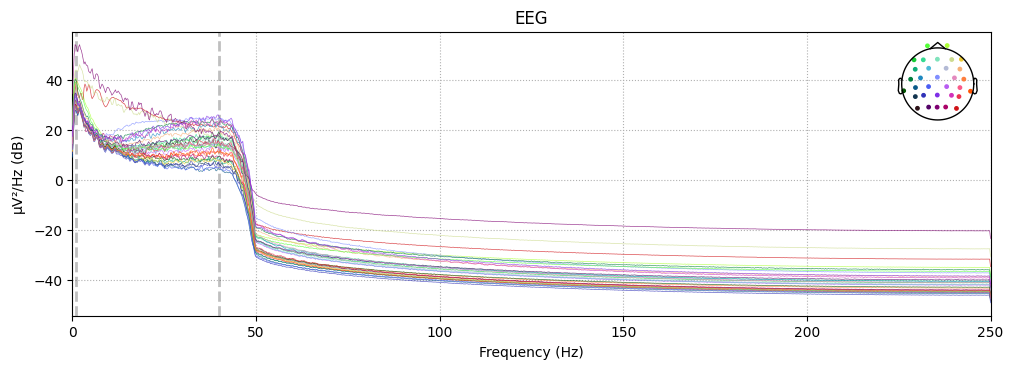

In [2]:
%matplotlib qt
raw.copy().set_eeg_reference('average').plot_psd()

In [3]:
raw.plot(precompute=False, scalings='auto')

Using qt as 2D backend.


Channels marked as bad:
['Cz', 'T7', 'PO10', 'Oz', 'C4', 'C3', 'F4', 'FC6']


In [4]:
raw.save(f'sub-{subject}_ses-{session}_annotated-raw.fif', overwrite=True)

Overwriting existing file.
Writing C:\Users\victor.ferat\Documents\GitHub\neuxus_test\sub-pilot6_ses-01_annotated-raw.fif
Closing C:\Users\victor.ferat\Documents\GitHub\neuxus_test\sub-pilot6_ses-01_annotated-raw.fif
[done]


In [5]:
from mne.preprocessing import ICA

rank = mne.compute_rank(raw)
ica = ICA(n_components=rank['eeg'], random_state=42, method='infomax', fit_params=dict(extended=True))
ica.fit(raw)

Computing rank from data with rank=None
Omitting 227896 of 1298750 (17.55%) samples, retaining 1070854 (82.45%) samples.
    Using tolerance 1.2e-10 (2.2e-16 eps * 24 dim * 2.2e+04  max singular value)
    Estimated rank (eeg): 24
    EEG: rank 24 computed from 24 data channels with 0 projectors
Fitting ICA to data using 24 channels (please be patient, this may take a while)
Omitting 227896 of 1298750 (17.55%) samples, retaining 1070854 (82.45%) samples.
Selecting by number: 24 components
Computing Extended Infomax ICA
Fitting ICA took 190.9s.


Method,infomax
Fit parameters,extended=Truemax_iter=500
Fit,500 iterations on raw data (1070854 samples)
ICA components,24
Available PCA components,24
Channel types,eeg
ICA components marked for exclusion,—


In [ ]:
%matplotlib qt
ica.plot_components(inst=raw)

In [6]:
ica.plot_sources(inst=raw) #gbhfgh

Creating RawArray with float64 data, n_channels=24, n_times=1298750
    Range : 0 ... 1298749 =      0.000 ...  2597.498 secs
Ready.


In [7]:
raw_ica = ica.apply(raw.copy())
raw_ica.interpolate_bads()
raw_ica.set_eeg_reference('average')

Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 4 ICA components
    Projecting back using 24 PCA components
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.0 mm
Computing interpolation matrix from 24 sensor positions
Interpolating 8 sensors
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,35 points
Good channels,32 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Setting 227896 of 1298750 (17.55%) samples to NaN, retaining 1070854 (82.45%) samples.
Effective window size : 4.096 (s)


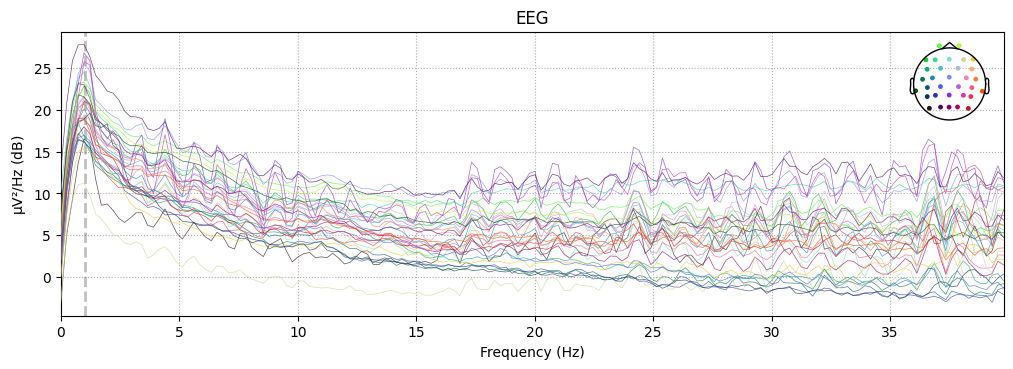

In [8]:
raw_ica.plot_psd(fmin=0, fmax=40)

In [9]:
raw_ica.save(fr'sub-{subject}_ses-{session}_annotated-preproc-raw.fif', overwrite=True)

Overwriting existing file.
Writing C:\Users\victor.ferat\Documents\GitHub\neuxus_test\sub-pilot6_ses-01_annotated-preproc-raw.fif
Closing C:\Users\victor.ferat\Documents\GitHub\neuxus_test\sub-pilot6_ses-01_annotated-preproc-raw.fif
[done]


In [17]:
import mne
import numpy as np
# Define the electrodes of interest
electrodes_OI_right = ['P4', 'P8', 'O2']
electrodes_OI_left = ['P3', 'P7', 'O1']
freqs = [8, 13]
# Compute the alpha power on average for the specified electrodes
duration = 2

psds = list()
for metadata in metadatas:
    raw_ = raw_ica.copy().crop(metadata['tmin'], metadata['tmax'])
    epochs_ = mne.make_fixed_length_epochs(raw_, duration=duration, overlap=0.5, preload=False)
    epochs_ = epochs_.drop_bad()
    if len(epochs_):
        tf = mne.time_frequency.psd_array_welch(epochs_.get_data( picks=electrodes_OI_right), raw.info['sfreq'], fmin=freqs[0], fmax=freqs[1],)
        alpha_power_right = np.average(np.average(tf[0], axis=2), axis=1)
    
        tf = mne.time_frequency.psd_array_welch(epochs_.get_data( picks=electrodes_OI_left), raw.info['sfreq'], fmin=freqs[0], fmax=freqs[1],)
        alpha_power_left = np.average(np.average(tf[0], axis=2), axis=1)
    
        metadata['alpha_power_right_dist'] = alpha_power_right
        metadata['alpha_power_left_dist'] = alpha_power_left
        metadata['alpha_power_right'] = np.average(alpha_power_right)
        metadata['alpha_power_left'] = np.average(alpha_power_left)
        
        for right, left  in zip(alpha_power_right, alpha_power_left):
            p = {'power': right - left,
                'side': 'right - left',
                 'run': metadata['run'],
                 'task': metadata['task']}
            psds.append(p)


Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 1000 original time points ...
10 bad epochs dropped
Using data from preloaded Raw for 12 events and 1000 original time points ...
Effective window size : 0.512 (s)
Using data from preloaded Raw for 12 events and 1000 original time points ...
Effective window size : 0.512 (s)
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 1000 original time points ...
5 bad epochs dropped
Using data from preloaded Raw for 17 events and 1000 original time points ...
Effective window size : 0.512 (s)
Using data from preloaded Raw for 17 events and 1000 original time points ...
Effective window size : 0.512 (s)
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2

C:\Users\victor.ferat\AppData\Local\Temp\ipykernel_45536\2831766921.py:14: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs_ = epochs_.drop_bad()


Effective window size : 0.512 (s)
Using data from preloaded Raw for 21 events and 1000 original time points ...
Effective window size : 0.512 (s)
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 1000 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 20 events and 1000 original time points ...
Effective window size : 0.512 (s)
Using data from preloaded Raw for 20 events and 1000 original time points ...
Effective window size : 0.512 (s)
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 1000 original time points ...
19 bad epochs dropped
Using data from preloaded Raw for 3 events and 1000 original time points ...
Effective window size : 0.512 (s)
Using data from preloaded Raw for 3 events and 1000 original time points ...
Effective window size : 0.512 (

In [18]:
import pandas as pd
df = pd.DataFrame(psds)

def new(row):
    run = row['run']
    task = row['task']
    if task == 'neurofeedback':
        if run == '10':
            run = '13'
        elif run == '11':
            run = '14'       
        elif run == '12':
            run = '15'
    elif task == 'transfer':
        task = 'neurofeedback'
        if run == '01':
            run = '10'
        elif run == '02':
            run = '11'       
        elif run == '03':
            run = '12'
    return(task, run)

df[['new_task', 'new_run']] = [new(row) for r, row in df.iterrows()]
df['task_run'] = df['new_task'] + '_' + df['new_run']
df

,power,side,run,task,new_task,new_run,task_run
0,-4.880520e-11,right - left,01,baseline,baseline,01,baseline_01
1,-3.598779e-12,right - left,01,baseline,baseline,01,baseline_01
2,-6.131700e-12,right - left,01,baseline,baseline,01,baseline_01
3,-3.615789e-12,right - left,01,baseline,baseline,01,baseline_01
4,4.795887e-13,right - left,01,baseline,baseline,01,baseline_01
...,...,...,...,...,...,...,...
1287,8.051868e-13,right - left,03,transfer,neurofeedback,12,neurofeedback_12
1288,-3.021593e-12,right - left,03,transfer,neurofeedback,12,neurofeedback_12
1289,3.681550e-12,right - left,03,transfer,neurofeedback,12,neurofeedback_12
1290,3.921133e-13,right - left,03,transfer,neurofeedback,12,neurofeedback_12


In [24]:
runs_nf

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '13', '14',
       '15', '10', '11', '12'], dtype=object)

c:\Users\victor.ferat\AppData\Local\miniconda3\envs\soraya\lib\site-packages\dabest\_classes.py:2047: UserWarning: The upper limit of the interval was in the top 10 values. The result should be considered unstable.
  warnings.warn(err_temp.substitute(lim_type="upper",
c:\Users\victor.ferat\AppData\Local\miniconda3\envs\soraya\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\victor.ferat\AppData\Local\miniconda3\envs\soraya\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 71.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\victor.ferat\AppData\Local\miniconda3\envs\soraya\lib\site-packages\seaborn\categorical.py:3398: UserWarning: 41.2% of the points cannot be placed; you may want to decrease the size of the markers or use str

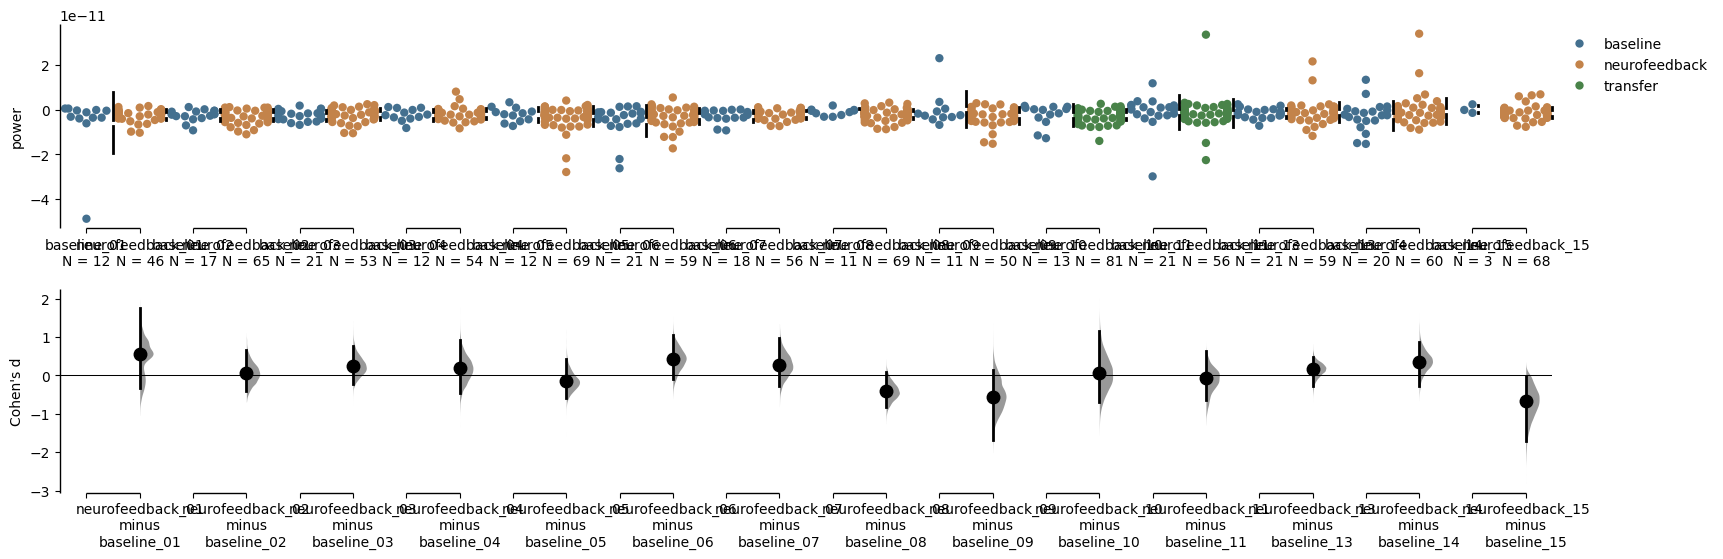

In [27]:
import dabest
import matplotlib.pyplot as plt

runs_nf = df[df['new_task'] == 'neurofeedback']['new_run'].unique()
runs_baseline = df[df['new_task'] == 'baseline']['new_run'].unique()
runs = np.intersect1d(runs_nf, runs_baseline)
runs.sort()
idx = [(f"baseline_{i}", f"neurofeedback_{i}") for i in runs]

unpaired = dabest.load(data = df,
                          idx=idx,
                          x="task_run", y="power")

unpaired.cohens_d.plot(color_col='task')

In [28]:
import seaborn as sns

order = df[df['new_task'] == 'neurofeedback']['task_run'].unique()
order.sort()
xticks_labels = [o.split('_')[-1] for o in order]
xticks = np.arange(len(xticks_labels))

fig, ax = plt.subplots()
sns.boxplot(data=df, x='task_run', y='power',order=order, ax=ax)
ax.set_xticks(xticks, xticks_labels)

ax.hlines(y=0, xmin=-1, xmax=xticks.max()+1, color='red')

plt.show()